In [5]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f804c917fcb8a70cadf37dcca99a06268e90b1fa4b9864f9d5411597e373350e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!pip install pyspark_dist_explore #used for exploring and visualizing distributions of data

In [ ]:
import pyspark

# IMPORTING NECESSARY LIBRARIES

In [6]:
import warnings
import pandas as pd
import seaborn as sns
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# STARTING THE SPARK SESSION

In [7]:
spark = SparkSession.builder.master("local[1]").appName("PySpark-Churn").getOrCreate()

In [8]:
spark

In [9]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=PySpark-Churn>

#UPLOADING THE DATASET

In [10]:
from google.colab import files
uploaded = files.upload()


Saving Churn_Modelling.csv to Churn_Modelling.csv


In [11]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("ChurnAnalysis").getOrCreate()

# Load the dataset as a PySpark DataFrame
df = spark.read.csv('Churn_Modelling.csv', header=True, inferSchema=True)


#ABOUT THE DATASET

In [14]:
#Data types of the columns in dataset
df.dtypes

[('RowNumber', 'int'),
 ('CustomerId', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [15]:
#Reading the first row of the dataset
df.head()

Row(RowNumber=1, CustomerId=15634602, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard=1, IsActiveMember=1, EstimatedSalary=101348.88, Exited=1)

In [49]:
# Count for the columns
print("Shape: ", (df.count(), len(df.columns)))

Shape:  (10000, 14)


In [18]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import matplotlib.pyplot as plt

#SUMMARY STATISTICS


In [19]:
# Summary statistics
summary_statistics = df.describe()
print(summary_statistics)

DataFrame[summary: string, RowNumber: string, CustomerId: string, Surname: string, CreditScore: string, Geography: string, Gender: string, Age: string, Tenure: string, Balance: string, NumOfProducts: string, HasCrCard: string, IsActiveMember: string, EstimatedSalary: string, Exited: string]


# MISSING VALUES

In [20]:
# Check for missing values
df.select([F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col) for col in df.columns]).show()


#NO MISSING VALUES WERE FOUND

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



#UNDERSTANDING THE DATASET

In [25]:
# The average of the age variable was taken according to the dependent variable.
from pyspark.sql.functions import mean
result = df.groupBy("exited").agg(mean("age").alias("average_age"))
result.show()

+------+-----------------+
|exited|      average_age|
+------+-----------------+
|     1| 44.8379970544919|
|     0|37.40838879819164|
+------+-----------------+



In [27]:
# Calculate the average age grouped by the "gender" variable
result = df.groupBy("gender").agg(mean("age").alias("average_age"))

# Show the result
result.show()


+------+------------------+
|gender|       average_age|
+------+------------------+
|Female|39.238388729914156|
|  Male|38.658237126626354|
+------+------------------+



In [28]:
# Calculate the average "exited" variable grouped by the "geography" variable
result = df.groupBy("geography").agg(mean("exited").alias("average_exited"))

# Show the result
result.show()

+---------+-------------------+
|geography|     average_exited|
+---------+-------------------+
|  Germany|0.32443204463929853|
|   France|0.16154766653370561|
|    Spain| 0.1667339523617279|
+---------+-------------------+



# Data Distribution and Visualization

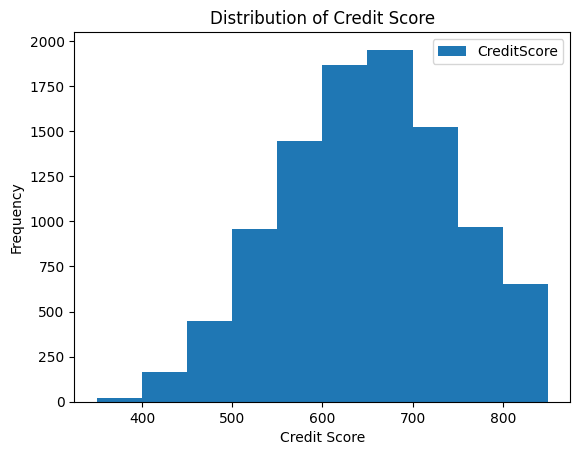

In [21]:
#FREQUENCY OF CREDIT SCORE
df.select("CreditScore").toPandas().plot(kind="hist", title="Distribution of Credit Score")
plt.xlabel("Credit Score")
plt.show()

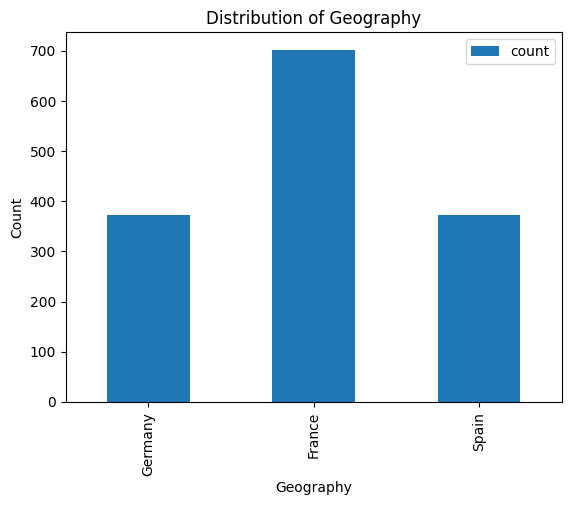

In [ ]:
#GEOGRAPHICAL DISTRIBUTION
df.groupBy("Geography").count().toPandas().plot(kind="bar", x="Geography", y="count", title="Distribution of Geography")
plt.xlabel("Geography")
plt.ylabel("Count")
plt.show()

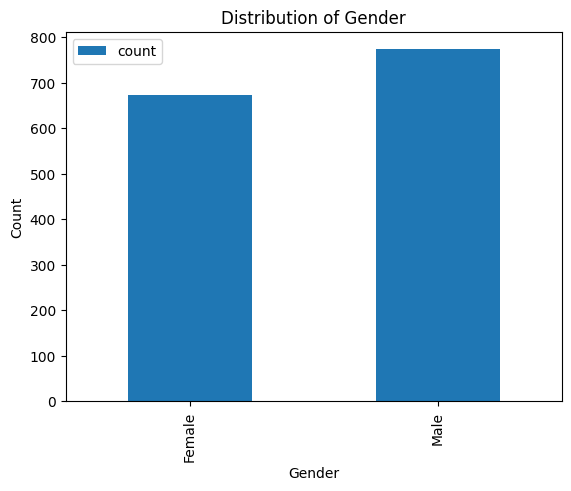

In [ ]:
#GENDER DISTRIBUTION
df.groupBy("Gender").count().toPandas().plot(kind="bar", x="Gender", y="count", title="Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

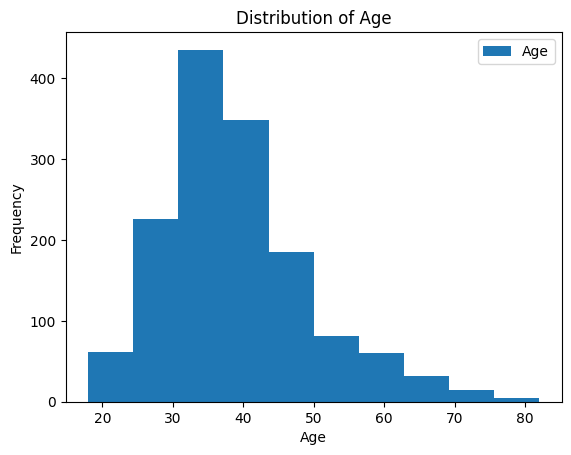

In [ ]:
#AGE DISTRIBUTION
df.select("Age").toPandas().plot(kind="hist", title="Distribution of Age")
plt.xlabel("Age")
plt.show()

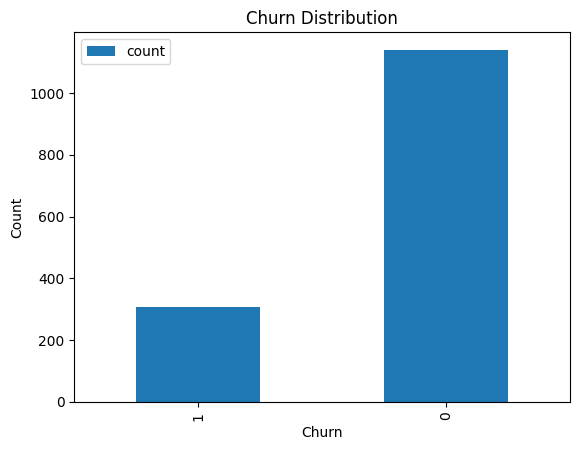

In [ ]:
#CHURN DISTRIBUTION
df.groupBy("Exited").count().toPandas().plot(kind="bar", x="Exited", y="count", title="Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

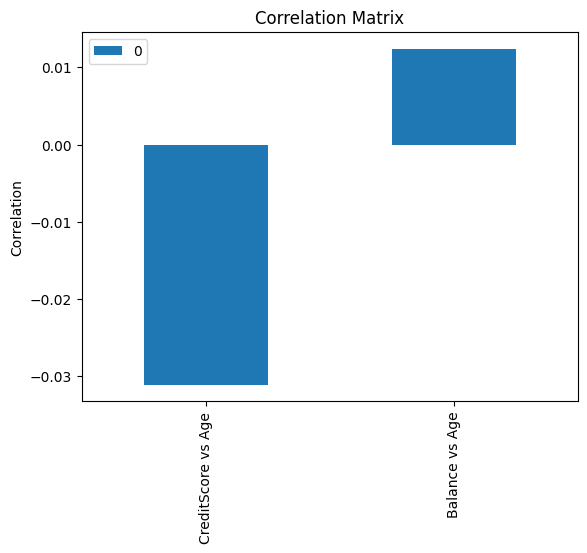

In [ ]:
#CORRELATION MATRIX
corr_matrix = df.select([F.corr("CreditScore", "Age"), F.corr("Balance", "Age")]).toPandas()
corr_matrix.columns = ["CreditScore vs Age", "Balance vs Age"]
corr_matrix.T.plot(kind="bar", title="Correlation Matrix")
plt.ylabel("Correlation")
plt.show()

# Distribution of the dependent variable "exited"

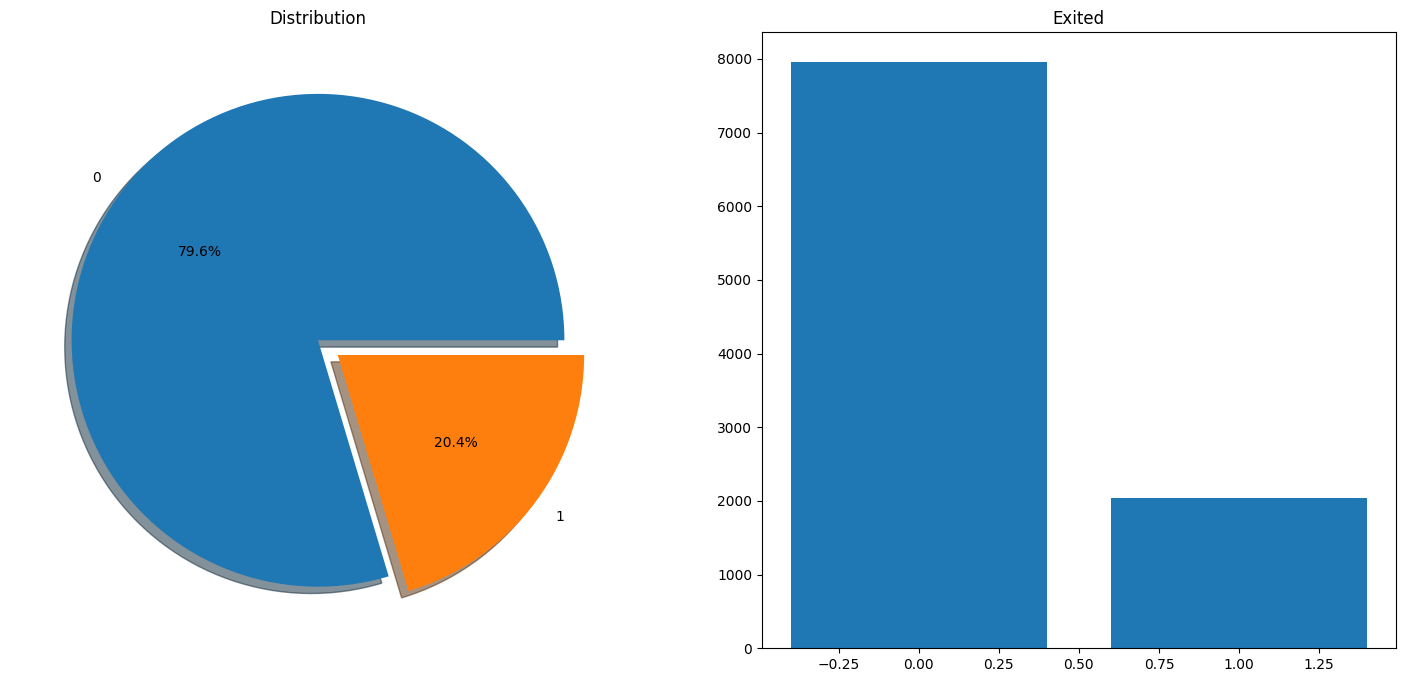

In [29]:
# Calculate the distribution of the "exited" variable
exited_counts = df.groupBy("exited").count().orderBy("exited")

# Convert the result to a Pandas DataFrame for visualization
exited_counts_pd = exited_counts.toPandas()

# Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot a pie chart
ax[0].pie(exited_counts_pd['count'], labels=exited_counts_pd['exited'], autopct='%1.1f%%', shadow=True, explode=(0, 0.1))
ax[0].set_title('Distribution')
ax[0].set_ylabel('')

# Plot a bar graph
ax[1].bar(exited_counts_pd['exited'], exited_counts_pd['count'])
ax[1].set_title('Exited')

# Show the plots
plt.show()

The plot generated provides insights into the distribution of the dependent variable "exited" in the dataset.
It consists of two subplots: a pie chart and a bar graph.

Pie Chart (left):

The pie chart visualizes the distribution of the "exited" variable.
Each slice of the pie represents a category of "exited," which typically corresponds to two values (e.g., "Exited" and "Not Exited" or "1" and "0").
The size of each slice is proportional to the number of records that fall into that category.
The percentage labels inside each slice show the proportion of records in that category relative to the total.

Bar Graph (right):

The bar graph shows the same distribution, but it represents the counts of each category using vertical bars.
Each bar corresponds to a category, and the height of the bar represents the count of records in that category.
What it tells us:









# Distribution of the dependent variable ("exited") based on the "gender" variable

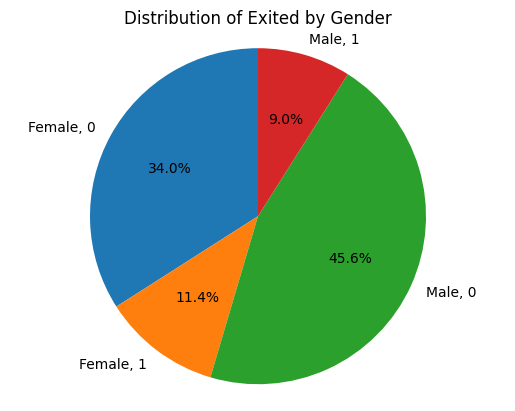

In [42]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

# Group the data by "gender" and "exited," and count the occurrences
gender_exited_counts = df.groupBy("gender", "exited").count()

# Convert the result to a Pandas DataFrame
gender_exited_counts_pd = gender_exited_counts.toPandas()

# Pivot the data to create a table suitable for a pie chart
pivot_table = gender_exited_counts_pd.pivot(index="gender", columns="exited", values="count")

# Flatten the pivot_table to create a 1D array
data = pivot_table.values.flatten()

# Labels for the pie chart
labels = ["Female, 0", "Female, 1", "Male, 0", "Male, 1"]

# Plot a pie chart
fig, ax = plt.subplots()
ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title("Distribution of Exited by Gender")
plt.show()


The pie chart is created using the distribution of the dependent variable ("exited") based on the "gender" variable provides insights into how customer churn (exiting) is distributed among different gender categories.

Each section of the pie chart represents a combination of gender and the "exited" variable.

Here's what the pie chart explains:

1. **Distribution by Gender**:
   - The chart is divided into two major sections, each representing a gender category: "Female" and "Male." T

2. **"Exited" Categories**:
   - Each major section (Female and Male) is further divided into two smaller sections: "0" and "1." These represent the "exited" variable, where "0" typically means customers who have not exited (churned), and "1" represents customers who have exited (churned).

3. **Proportion of Churn**:
   - The size of each smaller section (0 or 1) within a gender category indicates the proportion of customers in that category who have either churned ("1") or remained ("0").

4. **Percentage Labels**:
   - The percentage labels inside each section show the percentage of customers in that specific category who have exited. For example, if you have "Female, 1" with a label of "20.0%," it means that 20% of the female customers in your dataset have churned.

The pie chart provides a visual representation of how customer churn is distributed among different gender categories. It allows you to quickly compare the churn rates for male and female customers.

# 2x2 grid of count plots to explore the relationship between categorical variables and the dependent variable "Exited."

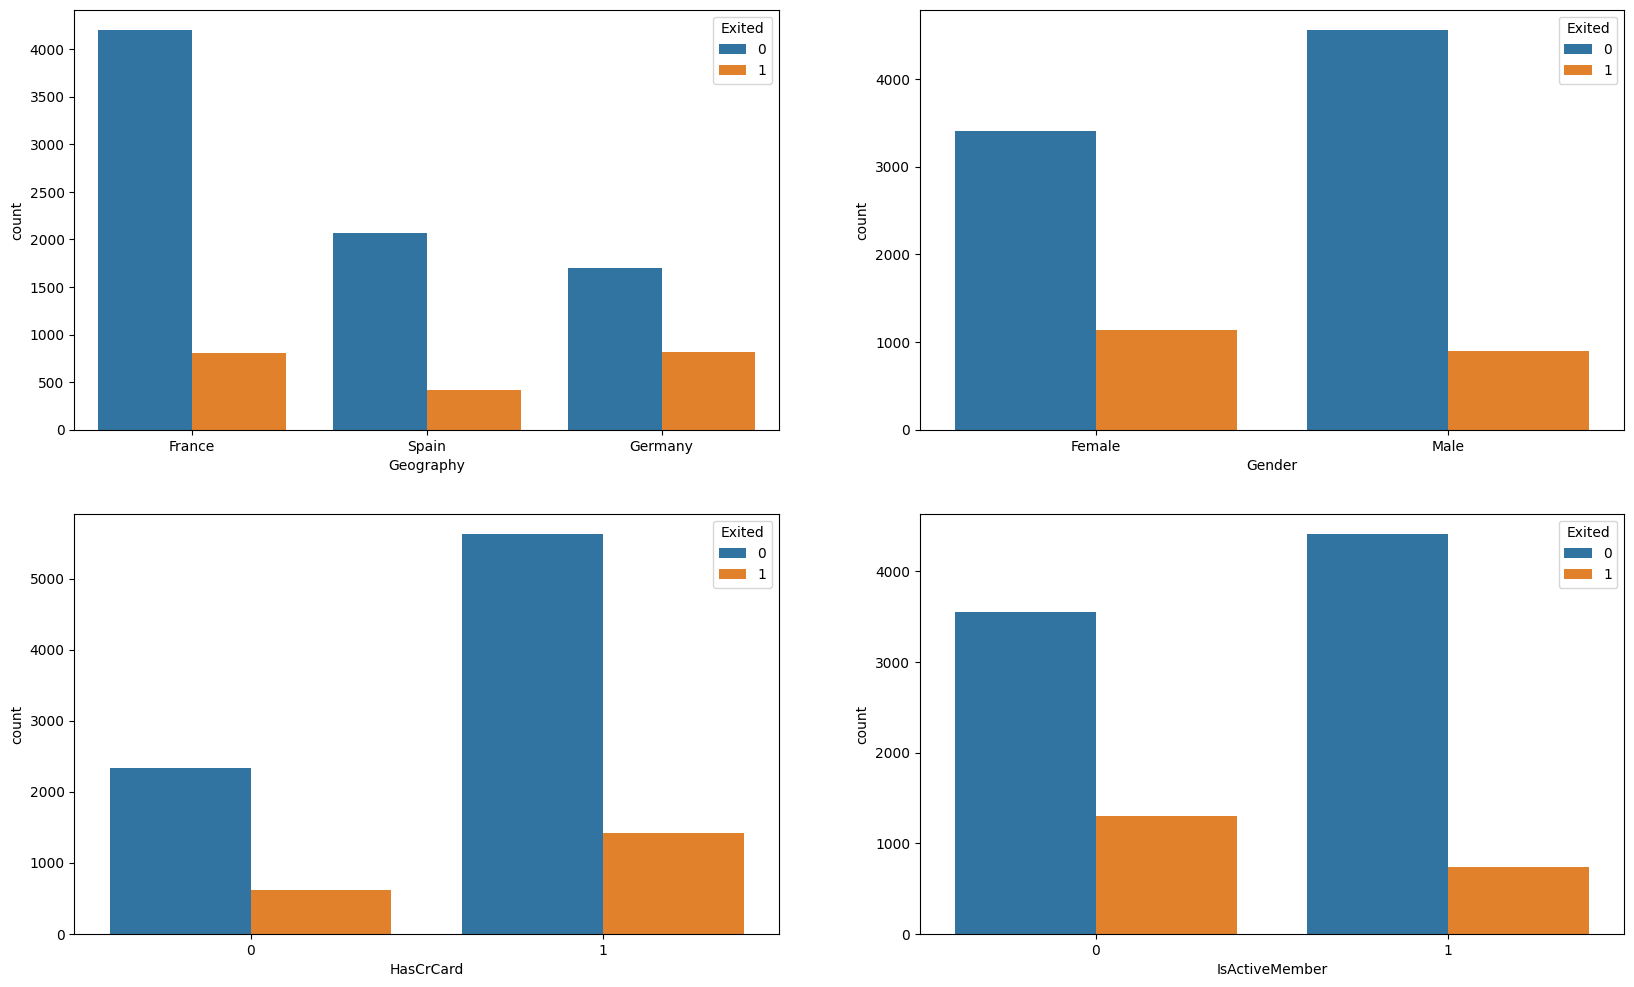

In [46]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

df_pd = df.toPandas()

# Create subplots
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))

# Plot the categorical variables based on the "exited" variable
sns.countplot(x='Geography', hue='Exited', data=df_pd, ax=axarr[0, 0])
sns.countplot(x='Gender', hue='Exited', data=df_pd, ax=axarr[0, 1])
sns.countplot(x='HasCrCard', hue='Exited', data=df_pd, ax=axarr[1, 0])
sns.countplot(x='IsActiveMember', hue='Exited', data=df_pd, ax=axarr[1, 1])

# Show the plots
plt.show()


This is a 2x2 grid of count plots using the Seaborn library to explore the relationship between categorical variables and the dependent variable "Exited." Each subplot in the grid displays the distribution of "Exited" based on a different categorical variable.

1. **Geography vs. Exited** (Top-Left Plot):
   - The top-left plot shows the distribution of "Exited" (churned or not churned) based on the "Geography" variable. Each bar represents a geographical location, and the bars are divided into two sections: "0" and "1." "0" typically means customers who have not exited (churned), and "1" represents customers who have exited (churned).
   
  - This plot allows us to compare the churn rates for different geographical locations.

2. **Gender vs. Exited** (Top-Right Plot):
   - The top-right plot shows the distribution of "Exited" based on the "Gender" variable. The bars are divided into "0" and "1," representing the churn status for different genders (e.g., "Male" and "Female").
   
   - This plot helps us compare the churn rates between male and female customers.

3. **Has Credit Card vs. Exited** (Bottom-Left Plot):
   - The bottom-left plot displays the distribution of "Exited" based on the "HasCrCard" variable. The bars represent customers with and without a credit card ("0" and "1").
   
   - We can analyze how having a credit card relates to customer churn.

4. **Active Membership vs. Exited** (Bottom-Right Plot):
   - The bottom-right plot shows the distribution of "Exited" based on the "IsActiveMember" variable. The bars represent customers who are active members ("1") and those who are not active members ("0").
   
   - This plot helps us understand the relationship between active membership and customer churn.

Overall, this set of count plots provides a visual exploration of how different categorical variables are related to the "Exited" variable, which typically represents customer churn.

# Relationship between the dependent variable ("Exited") and two independent variables: "Age" and "Geography."

In [44]:
import pandas as pd
import plotly.express as px

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Create the bar chart using Plotly Express
fig = px.bar(df_pd, y="Exited", x="Age", color="Geography")
fig.show()


The bar chart created using Plotly Express explains the relationship between the dependent variable ("Exited") and two independent variables: "Age" and "Geography."

1. **X-Axis (Age)**: The X-axis represents the age of the customers. Each bar on the X-axis corresponds to a specific age group.

2. **Y-Axis (Exited)**: The Y-axis represents the dependent variable "Exited," which typically indicates whether a customer has churned (1) or not (0).

- The Y-axis shows the count of customers in each age group who have exited (churned).

3. **Color (Geography)**: The color of each bar is determined by the "Geography" variable, which could represent the geographical location of customers.

4. **Bar Heights**: The height of each bar represents the count of customers in a specific age group who have exited (churned).

- Taller bars indicate a higher count of churned customers in that age group.

In summary, the bar chart provides insights into how customer churn is distributed among different age groups, and it allows you to visually compare the churn counts for different geographical locations within each age group.

# Relationships between numerical variables in your dataset

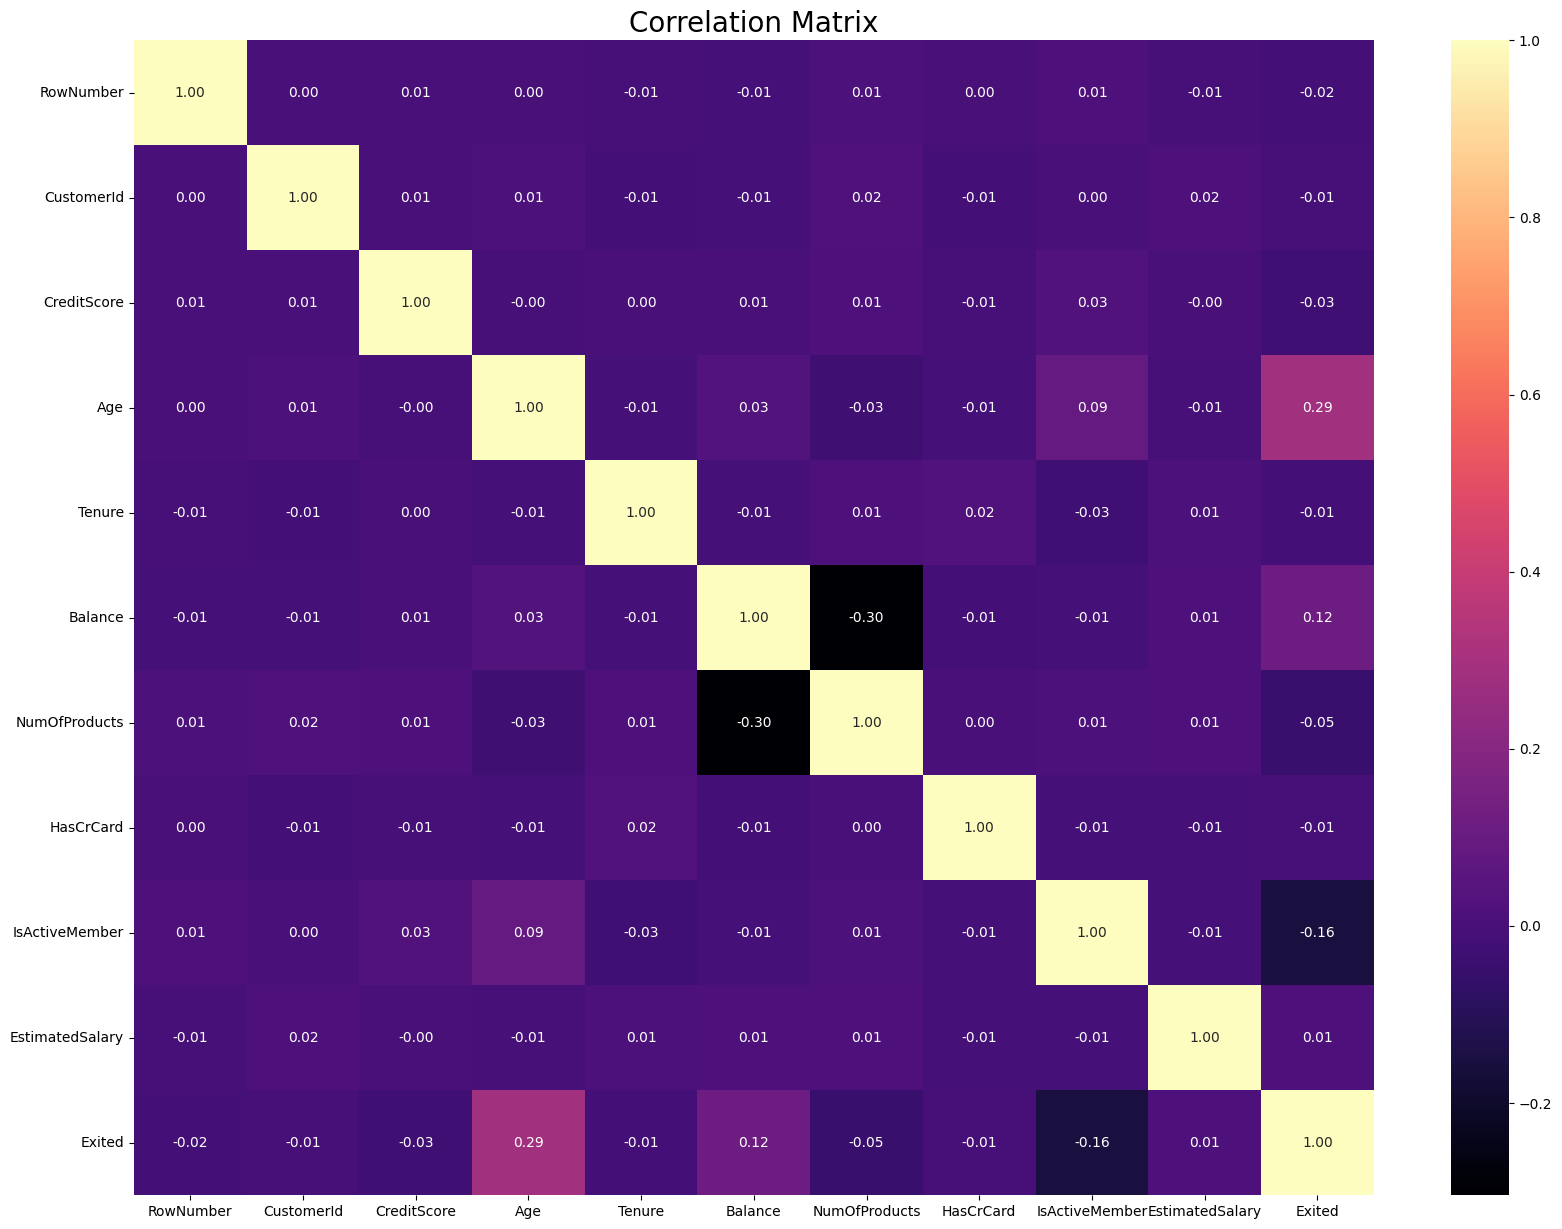

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Create a correlation matrix
corr_matrix = df_pd.corr()

# Create a heatmap of the correlation matrix
f, ax = plt.subplots(figsize=[20, 15])
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()


The heatmap of the correlation matrix provides insights into the relationships between numerical variables in the dataset.

1. **Color Intensity**: The colors in the heatmap represent the strength and direction of the correlation between pairs of variables.

 - Positive correlations (closer to 1) are shown in lighter shades (toward yellow), while
 - negative correlations (closer to -1) are displayed in darker shades (toward purple).
 - Values close to 0 appear in shades of gray.

2. **Annotations**: The numbers within each cell of the heatmap indicate the correlation coefficients. These coefficients quantify the strength and direction of the linear relationship between two variables.

 - A positive coefficient means that the variables move together, while a
 - negative coefficient indicates they move in opposite directions.

3. **Correlation Strength**: Variables with a correlation coefficient close to 1 or -1 have a strong linear relationship.
Variables with a coefficient close to 0 are weakly correlated or uncorrelated.


Overall, the heatmap is a valuable tool for understanding the relationships between numerical variables in your dataset and for identifying patterns and dependencies that can inform further analysis, modeling, or decision-making.

# Potential outliers in numerical variables in your dataset, based on the "Exited" variable

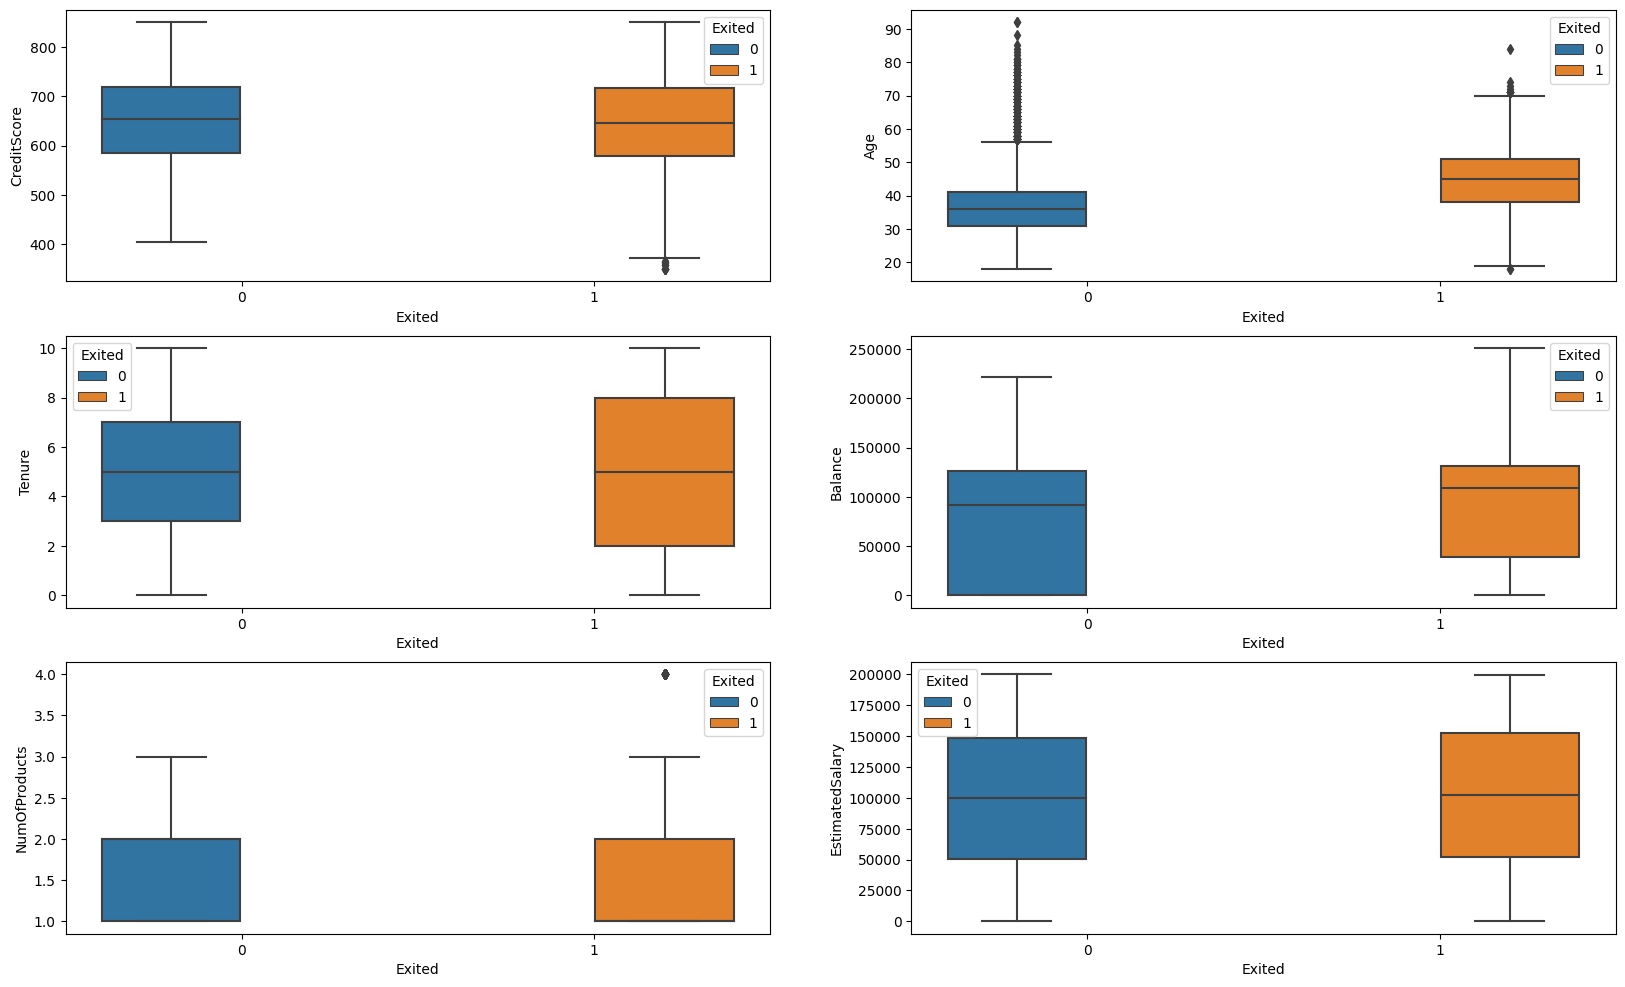

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Create subplots for boxplots
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))

# Plot boxplots for outlier analysis
sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=df_pd, ax=axarr[0, 0])
sns.boxplot(y='Age', x='Exited', hue='Exited', data=df_pd, ax=axarr[0, 1])
sns.boxplot(y='Tenure', x='Exited', hue='Exited', data=df_pd, ax=axarr[1, 0])
sns.boxplot(y='Balance', x='Exited', hue='Exited', data=df_pd, ax=axarr[1, 1])
sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=df_pd, ax=axarr[2, 0])
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited', data=df_pd, ax=axarr[2, 1])

# Show the boxplot graphs
plt.show()


The boxplot graphs explain the distribution and potential outliers in numerical variables in your dataset, based on the "Exited" variable.

1. **CreditScore vs. Exited** (Top-Left Plot):
   - The boxplot shows the distribution of credit scores for two groups: customers who exited (churned) and those who did not.

   - It provides insights into the central tendency, spread, and presence of outliers in credit scores for both groups.

2. **Age vs. Exited** (Top-Right Plot):
   - This boxplot displays the age distribution for customers in the same two groups: exited and not exited.

   - It helps us understand the age distribution of churned and non-churned customers and identifies any potential age-related patterns.

3. **Tenure vs. Exited** (Middle-Left Plot):
   - The middle-left boxplot focuses on the distribution of tenure (the number of months a customer has been with the company) for churned and non-churned customers.

   - It provides insights into customer loyalty and tenure as they relate to churn.

4. **Balance vs. Exited** (Middle-Right Plot):
   - This boxplot illustrates the balance distribution in the context of customer churn.

   - It helps us understand the balance levels of customers who exited and those who remained, revealing potential patterns or outliers.

5. **NumOfProducts vs. Exited** (Bottom-Left Plot):
   - The bottom-left plot shows the distribution of the number of products a customer has with the company (e.g., accounts, services) for exited and non-exited customers.

   - It can help us understand the impact of the number of products on churn.

6. **EstimatedSalary vs. Exited** (Bottom-Right Plot):
   - The last boxplot represents the distribution of estimated salaries for both churned and non-churned customers.

   - It offers insights into whether estimated salary levels are associated with churn behavior.

Each boxplot displays the median (line inside the box), interquartile range (box), and potential outliers (individual data points beyond the "whiskers").

By examining these boxplots, we can identify any differences in the distributions of these variables between churned and non-churned customers and assess whether there are notable outliers or patterns that might be relevant to understanding customer churn.

# THANK YOU, NOW YOU CAN STOP THE SPARK SESSION!

In [ ]:
# Stop the Spark session
spark.stop()